In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# import packages to use in notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
import yfinance as yf

## Mini Project 1
### Portfolio Construction

Goal: The goal of this notebook is to use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- I will also explain my interpretation of the high and low risk profiles, and I will provide some measurable quantitative data in the explanation.

### Risk
A high-risk portfolio chases higher returns with greater uncertainty (volitility), while a low-risk portfolio prioritizes capital preservation and steady growth. The choice of portfolio depends on the investor's goals, timeline, and comfort with risk.

In this context, if the portfolio is higher risk (meaning more volitility), then we accept that risk at the potential reward of higher expected returns to compensate for the higher volitility. On the other hand, if the portfolio is low risk (meaning less volitility), then we would expect more modest but steady returns.

In this notebook, I will use a typical method of finding volatility: 1) find the (log) daily returns, 2) take standard deviation, and 3) multiply by sqrt(252) to give the yearly volatility.

So, let's do this for an example stock / index, VOO.

In [3]:
#load data for VOO over the past year using yf
ticker = 'VOO'   #ticker symbol
start_date = dt.datetime.today()-dt.timedelta(days = 365)   #set start date to 1 year ago
end_date = dt.datetime.today()   #set end date to today
stock = yf.download(ticker, start = start_date, end = end_date)   #pull stock data from the past year

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


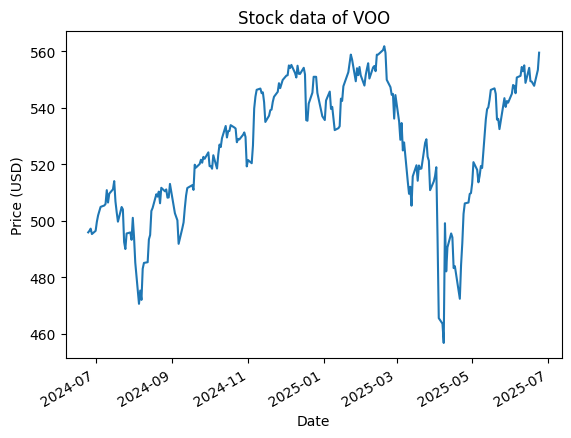

In [4]:
#plot data for VOO
stock['Close'][ticker].plot()   #get price of VOO at close over the selected dates and plot it
plt.title(f'Stock data of {ticker}')
plt.ylabel('Price (USD)')
plt.show()

In [5]:
#get log of daily returns for VOO and drop empty entries
VOO_close = stock['Close']['VOO']   #value of stock at close over selected dates
VOO_daily_log_returns = np.log(VOO_close/VOO_close.shift(1))   #calculate log daily returns of VOO
VOO_daily_log_returns = VOO_daily_log_returns.dropna()   #drop empty / nan values

In [6]:
#get returns and volatility metrics for VOO
VOO_returns = VOO_daily_log_returns.mean()*252   #average returns
VOO_volatility = np.std(VOO_daily_log_returns)*np.sqrt(252)   #volitility of returns

In [7]:
print(f'Expected log-annualized returns of {ticker} is {VOO_returns}')
print(f'Volatility log-annualized of {ticker} is {VOO_volatility}')

Expected log-annualized returns of VOO is 0.12208861595610355
Volatility log-annualized of VOO is 0.1956929000578157


In [8]:
#function to characterize the log annual returns, volatility, and volatility per returns for a given stock
def characterize(ticker):
    # go through same process as above, but for a general stock, ticker
    close = stock['Close'][ticker]
    daily_log_returns = np.log(close/close.shift(1))
    daily_log_returns = daily_log_returns.dropna()
    returns = daily_log_returns.mean()*252
    volatility = np.std(daily_log_returns)*np.sqrt(252)
    return returns, volatility, volatility/returns

In [9]:
#load data for other stocks to test the characterize function above
ticker = ['TSLA', 'NVDA', 'AAPL']
start_date = dt.datetime.today()-dt.timedelta(days = 365)
end_date = dt.datetime.today()
stock = yf.download(ticker, start = start_date, end =end_date)

[*********************100%***********************]  3 of 3 completed


In [10]:
header = f"{'Stock':<8}{'Returns':>12}{'Volatility':>14}{'Vol/Ret':>12}"
print(header)
print('-' * len(header))

for t in ticker:
    ret, vol, ratio = characterize(t)
    print(f"{t:<8}{ret:>12.3}{vol:>14.3}{ratio:>12.3f}")

Stock        Returns    Volatility     Vol/Ret
----------------------------------------------
TSLA           0.605         0.738       1.220
NVDA           0.162         0.576       3.561
AAPL         -0.0386          0.32      -8.287


### High Risk vs Low Risk Portfolios
#### High Risk (growth and volatility)
In this portfolio, we are looking for growth and we can tolerate volitility. We are okay with large short term swings as they may lead to large long term profits; this is suited for investors with high risk tolerance.

Quantitatively, we're looking for high annualized volatility with high expected returns. So, we can try to maximum the returns with scipy independent of the volatility (and volatility should follow naturally). Also, here we will choose a smaller time window (3 years) to highlight recent market fluctuations.

Sectors like tech, biotech, emerging markets, or small-cap stocks are historically volitile stocks with large returns, so we'll start here.

#### Low Risk (stability and income)
In this portfolio, we want to minimize volitility while maintaining some level of positive daily returns; the goal is capital preservation with moderate growth. We want stable and modest expected returns with low volatility.

Quantitatively, we're looking for a large ratio of returns to volatility (i.e., high return per unit risk). Or, if we want to use the minimize function of scipy, we want to minimize the volatility to returns ratio (i.e., low volatility per unit return). Also, here we will choose a larger time window (5 years) to average out recent market fluctuations. This will give more accurate long-term trends.

Here, large market indexes or classic, blue-chip stocks would be a good place to start.

### Low Risk Portfolio

In [11]:
#note: sometimes importing this many tickers at once causes yfinance to crash
tickers = [
    # Tech
    'AAPL', 'GOOGL', 'NVDA',

    # Consumer
    'AMZN', 'WMT', 'COST',

    # Healthcare
    'JNJ', 'ABBV', 'LLY',

    # Financials
    'JPM', 'GS', 'BRK-B',

    # Energy & Industrials
    'XOM', 'CAT', 'GE',

    # Index ETFs
    'VOO', 'SPY', 'DIA'
]

In [12]:
start_date = dt.datetime.today()-dt.timedelta(days = 5*365)
end_date = dt.datetime.today()

stock = yf.download(tickers, start = start_date, end = end_date)

[*********************100%***********************]  18 of 18 completed


### Here's the goal:
- start with a large colleciton of big reliable stocks, and eliminate the ones with large volatility to returns ratios or those with negative returns
- then, with a refined list of stocks (that have small volatility to returns ratios), assign weights through scipy minimize such that we find an optimial portfolio that minimizes the volatility to returns ratio

In [13]:
# create dictionary with stock metrics and only keeps those with positve returns and low ratios of volatility/returns
stock_metrics = {ticker: characterize(ticker) for ticker in tickers}
original_length = len( stock_metrics )
stock_metrics = {ticker: metrics for ticker, metrics in stock_metrics.items() if (metrics[0] > 0 and metrics[-1] <= 2)} #this drops stocks with negative returns and high vol/ret ratios

In [14]:
#sort filtered stocks by volatility/returns
stock_metrics = dict(sorted(stock_metrics.items(), key=lambda item: item[1][2]))
filtered_length = len( stock_metrics )

In [15]:
print('Original list ' + str(original_length))
print('Filtered list ' + str(filtered_length))
print('Filtered out ' + str(original_length - filtered_length) + ' stocks from original list')

Original list 18
Filtered list 16
Filtered out 2 stocks from original list


In [16]:
filtered_tickers = list(stock_metrics.keys())
print( filtered_tickers )

['GE', 'BRK-B', 'COST', 'NVDA', 'LLY', 'GS', 'JPM', 'WMT', 'VOO', 'SPY', 'CAT', 'DIA', 'XOM', 'ABBV', 'GOOGL', 'AAPL']


In [17]:
# Get only the 'Close' prices of the filtered tickers
filtered_close = stock['Close'][filtered_tickers]
# Now compute log returns
daily_returns = np.log(filtered_close / filtered_close.shift(1)).dropna()
# Mean returns
mean_returns = 252 * daily_returns.mean()
# Covariance matrix
cov_matrix = daily_returns.cov()

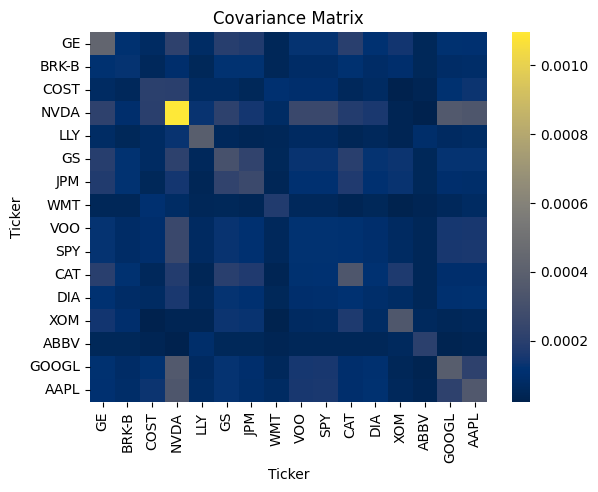

In [18]:
plt.figure()
sns.heatmap(cov_matrix, cmap='cividis', fmt ='.4f')
plt.title('Covariance Matrix')
plt.show()

In [19]:
#Find a set of weights, equivalently portfolio investment percentages in stock_symbols, 
#which minimizes a historical portfolio's volatility/returns ratio subject to the following investment constraints
#1) Must invest at least max(0.001, 0.2 / n_assets) of capital into each index... this ensures a diversified portfolio
#2) Cannot invest more than min(0.25, 3.0 / n_assets) of capital into a single index... this ensures we do not rely too heavily on one stock

# Number of assets
n_assets = filtered_length
min_bound = max(0.001, 0.2 / n_assets)
max_bound = min(0.25, 3.0 / n_assets)

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.ones(n_assets) / n_assets

# Define weight constraints
#Sum of weights equals 1 (we must invest all our money)
#Follow the bounds of weights from above
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1})
bounds = [(min_bound, max_bound)] * n_assets

# Define the objective function to minimize portfolio variance/returns ratio
def volatility_over_return(weights, mean_returns, covariance_matrix):
    # Portfolio return (dot product of weights and mean returns)
    port_return = np.dot(weights, mean_returns)
    # Portfolio volatility (standard deviation)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    # Avoid divide by zero
    if port_return == 0:
        return np.inf  # or a large number to penalize this set of weights
    return port_volatility / port_return

# Run the optimization to find the optimal weights that minimizes the vol/ret ratio, effectivly creating a low risk investment stratedgy
result = minimize(volatility_over_return, initial_weights,
                  args=(mean_returns, cov_matrix),
                  bounds=bounds, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

/Users/jakemcgrath/pyenv/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/jakemcgrath/pyenv/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Users/jakemcgrath/pyenv/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


In [20]:
# Zip tickers and weights together
weights_with_tickers = list(zip(filtered_tickers, optimal_weights))
# Sort by weight descending
sorted_weights = sorted(weights_with_tickers, key=lambda x: x[1], reverse=True)

In [21]:
# Print tickers with weights
print("Optimal Asset Weights to minimize volatility/return (sorted):")
for ticker, weight in sorted_weights:
    print(f"{ticker}: Weight = {weight:.4f}")

Optimal Asset Weights to minimize volatility/return (sorted):
GE: Weight = 0.1852
LLY: Weight = 0.1667
COST: Weight = 0.1298
WMT: Weight = 0.1296
NVDA: Weight = 0.0796
ABBV: Weight = 0.0774
BRK-B: Weight = 0.0666
XOM: Weight = 0.0651
GS: Weight = 0.0125
AAPL: Weight = 0.0125
VOO: Weight = 0.0125
GOOGL: Weight = 0.0125
SPY: Weight = 0.0125
JPM: Weight = 0.0125
CAT: Weight = 0.0125
DIA: Weight = 0.0125


In [22]:
print(f' The optimal volatility/return subject to the constraints is {result.fun}')

 The optimal volatility/return subject to the constraints is 0.036489342004474554


In [23]:
# Get only the Adjusted Close prices
close_value = stock['Close'][filtered_tickers]
# Normalize value to 1
normalized = close_value / close_value.iloc[0]
# Multiply by weights and sum across columns to get portfolio value
low_portfolio_value = (normalized * optimal_weights).sum(axis=1)

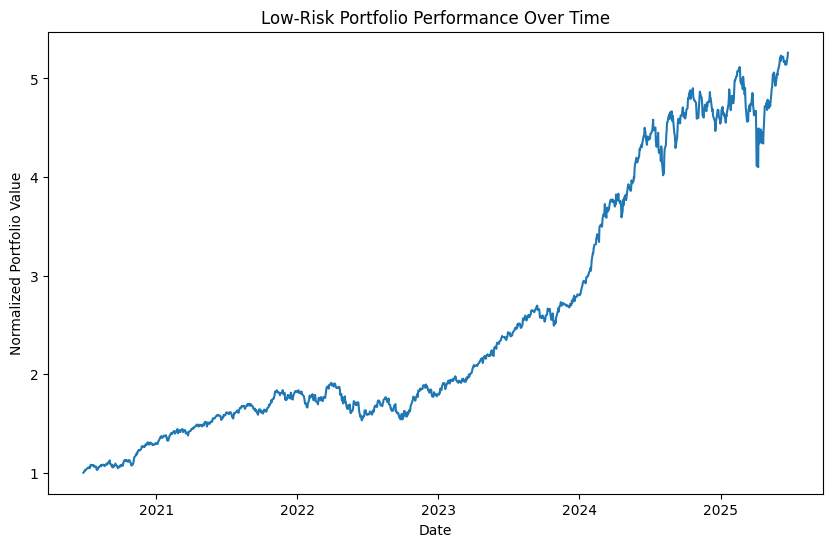

In [24]:
# Plot the portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(low_portfolio_value)
plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.title("Low-Risk Portfolio Performance Over Time")
plt.show()

In [25]:
print(f'Portfolio increased in value by {100*(low_portfolio_value.iloc[-1]-low_portfolio_value.iloc[0])/low_portfolio_value.iloc[0]:.2f}%')

Portfolio increased in value by 426.11%


In [26]:
close = low_portfolio_value
daily_log_returns = np.log(close/close.shift(1))
daily_log_returns = daily_log_returns.dropna()
low_returns = daily_log_returns.mean()*252
low_volatility = np.std(daily_log_returns)*np.sqrt(252)
low_ratio = low_volatility/low_returns

In [27]:
print(f'Final characteristics: returns: {low_returns:.3f}, volatility: {low_volatility:.3f}, volatility/returns: {low_ratio:.3f}')
print('Note: low volatility and low volatility/returns ratio... ie, you get more returns than volitility')

Final characteristics: returns: 0.334, volatility: 0.195, volatility/returns: 0.583
Note: low volatility and low volatility/returns ratio... ie, you get more returns than volitility


### High Risk Portfolio

In this portfolio, we want high returns and we're okay with volatility if that leads to large returns. Some quantitative metrics we can use to determine this high-risk-high-reward situation are:
- Annualized returns
- Volatility
- Beta (measures sensitivity to market movements)
- Maximum drawdown (Largest drop from peak to trough

However, what I'll do here is I'll try to maximize returns with volatility likely coming as a consequence. In order to pass to to scipy optimize, instead of maximizing returns, I want to minimize the negative of returns.

Similar as above, let's start with a collection of tickers from different sectors that are notorious for being high-risk-high-reward stocks and work from there.

In [28]:
# High-risk, high-reward stock tickers by sector
high_risk_tickers = [
    # Technology: Innovative, fast-growing, but volatile
    'NVDA','TSLA','AMD','PLTR','UPST','FSLY', 'UBER',

    # Biotechnology: Drug development with regulatory and trial risks
    'CRIS','GILD',

    # Emerging Markets: Growth with political and economic risks
    'BABA','JD','PDD','NIO',

    # Small-Cap Growth: Smaller companies with explosive growth potential but less stability
    'RIVN','PTON','ETSY','ROKU',

    # Cryptocurrency-related: Exposed to crypto market volatility
    'COIN','MARA','RIOT',
]

In [29]:
#importing this many tickers at once can cause it to crash
start_date = dt.datetime.today()-dt.timedelta(days = 3*365) #import data from past 3 years to highlight recent volitility
end_date = dt.datetime.today()

stock = yf.download(high_risk_tickers, start = start_date, end = end_date)

[**********************85%****************       ]  17 of 20 completedException in thread Thread-44 (_run_via_pool):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jakemcgrath/pyenv/lib/python3.13/site-packages/ipykernel/iostream.py", line 142, in _event_pipe
    event_pipe = self._local.event_pipe
AttributeError: '_thread._local' object has no attribute 'event_pipe'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/threading.py", line 1041, in _bootstrap_inner
    self.run()
  File "/Users/jakemcgrath/pyenv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/threading.py", line 992, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jakemcgrath/pyenv/lib/python3.13/site-pack

[*********************100%***********************]  20 of 20 completed

1 Failed download:
['RIVN']: DNSError('Failed to perform, curl: (6) getaddrinfo() thread failed to start. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


### Here's the goal:
- start with a large colleciton of risky stocks, and eliminate the ones with negative returns
- then, with a refined list of stocks, assign weights through scipy minimize such that we maximize returns (independent of volatility). This will certainly produce high-risk-high-reward stocks that are subject to high volatility
- then, at the end, i will compare the preformance of the high risk to the low risk profile

In [30]:
# create dictionary with stock metrics and only keeps those with positve returns and low ratios of volatility/returns
stock_metrics = {ticker: characterize(ticker) for ticker in high_risk_tickers}
original_length = len( stock_metrics )
stock_metrics = {ticker: metrics for ticker, metrics in stock_metrics.items() if (metrics[0] > 0)}
filtered_length = len( stock_metrics )

In [31]:
print('Original list ' + str(original_length))
print('Filtered list ' + str(filtered_length))
print('Filtered out ' + str(original_length - filtered_length) + ' stocks from original list')

Original list 20
Filtered list 13
Filtered out 7 stocks from original list


In [32]:
filtered_tickers = list(stock_metrics.keys())
print(filtered_tickers)

['NVDA', 'TSLA', 'AMD', 'PLTR', 'UPST', 'UBER', 'CRIS', 'GILD', 'BABA', 'PDD', 'COIN', 'MARA', 'RIOT']


In [33]:
# Get only the 'Close' prices of the filtered tickers
filtered_close = stock['Close'][filtered_tickers]
# Now compute log returns
daily_returns = np.log(filtered_close / filtered_close.shift(1)).dropna()
# Mean returns
mean_returns = 252 * daily_returns.mean()
# Covariance matrix
cov_matrix = daily_returns.cov()

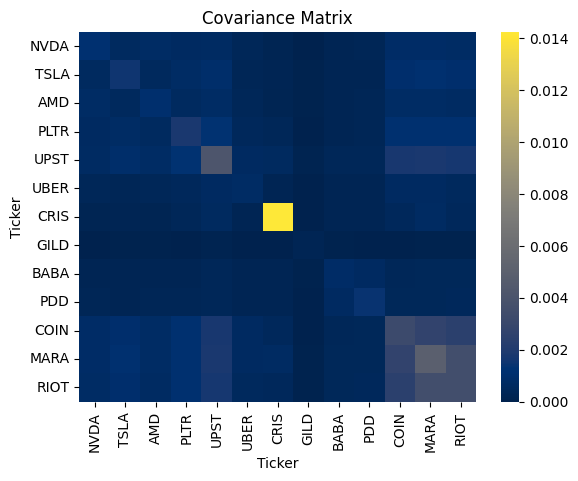

In [34]:
plt.figure()
sns.heatmap(cov_matrix, cmap='cividis', fmt ='.4f')
plt.title('Covariance Matrix')
plt.show()

In [35]:
#Find a set of weights, equivalently portfolio investment percentages in stock_symbols, 
#which maximizes the returns of a portfolio subject to the following contraints
#note: instead of maximizing returns, we are minimizing the negative of returns (which is effectively the same thing)
#1) Must invest at least max(0.001, 0.2 / n_assets) of capital into each index... this ensures a diversified portfolio
#2) Cannot invest more than min(0.25, 3.0 / n_assets) of capital into a single index... this ensures we do not rely too heavily on one stock

# Number of assets
n_assets = filtered_length
min_bound = max(0.001, 0.2 / n_assets)
max_bound = min(0.25, 3.0 / n_assets)

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.ones(n_assets) / n_assets

# Define weight constraints
#Sum of weights equals 1 
#Follow the bounds of weights from above
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1})
bounds = [(min_bound, max_bound)] * n_assets

# Define the objective function to maximize returns of the portfolio (or, min of neg returns)
def negative_return(weights, mean_returns, covariance_matrix):
    # Portfolio return (dot product of weights and mean returns)
    port_return = np.dot(weights, mean_returns)
    return -1*port_return

# Run the optimization to find the optimal weights
result = minimize(negative_return, initial_weights,
                  args=(mean_returns, cov_matrix),
                  bounds=bounds, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

In [36]:
# Zip tickers and weights together
weights_with_tickers = list(zip(filtered_tickers, optimal_weights))
# Sort by weight descending
sorted_weights = sorted(weights_with_tickers, key=lambda x: x[1], reverse=True)

In [37]:
# Print tickers with weights
print("Optimal Asset Weights to maximize return (sorted) independent of volitility:")
for ticker, weight in sorted_weights:
    print(f"{ticker}: Weight = {weight:.4f}")

Optimal Asset Weights to maximize return (sorted) independent of volitility:
NVDA: Weight = 0.2308
PLTR: Weight = 0.2308
COIN: Weight = 0.2308
UBER: Weight = 0.1692
GILD: Weight = 0.0154
BABA: Weight = 0.0154
CRIS: Weight = 0.0154
TSLA: Weight = 0.0154
AMD: Weight = 0.0154
UPST: Weight = 0.0154
PDD: Weight = 0.0154
MARA: Weight = 0.0154
RIOT: Weight = 0.0154


In [38]:
print(f' The optimal return subject to the constraints is {-1*result.fun}')

 The optimal return subject to the constraints is 0.6222829714179249


In [39]:
# Get only the Adjusted Close prices
close_value = stock['Close'][filtered_tickers]
# Normalize value to 1
normalized = close_value / close_value.iloc[0]
# Multiply by weights and sum across columns to get portfolio value
high_portfolio_value = (normalized * optimal_weights).sum(axis=1)

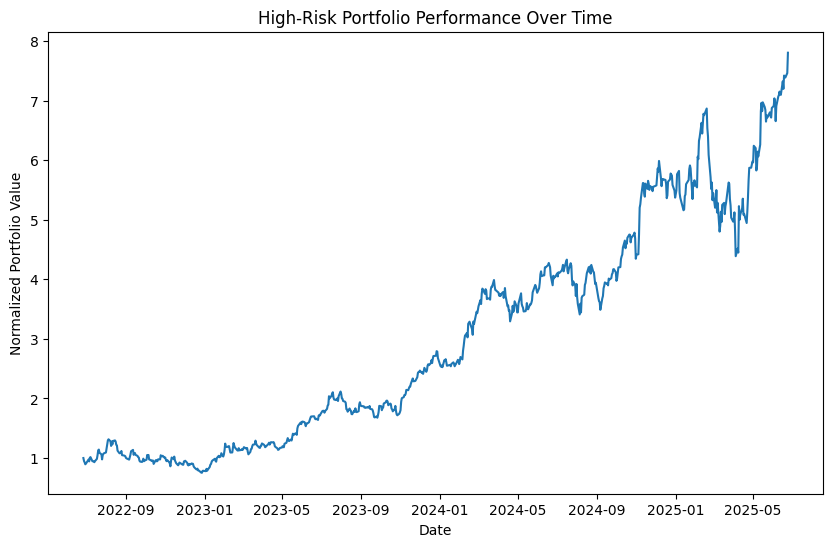

In [40]:
# Plot the portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(high_portfolio_value)
plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.title("High-Risk Portfolio Performance Over Time")
plt.show()

In [41]:
print(f'Portfolio increased in value by {100*(high_portfolio_value.iloc[-1]-high_portfolio_value.iloc[0])/high_portfolio_value.iloc[0]:.2f}%')

Portfolio increased in value by 680.25%


In [42]:
close = high_portfolio_value
daily_log_returns = np.log(close/close.shift(1))
daily_log_returns = daily_log_returns.dropna()
high_returns = daily_log_returns.mean()*252
high_volatility = np.std(daily_log_returns)*np.sqrt(252)
high_ratio = high_volatility/high_returns

In [43]:
print(f'Final characteristics: returns: {high_returns:.3f}, volatility: {high_volatility:.3f}, volatility/returns: {high_ratio:.3f}')
print('Note: high returns and volatility')

Final characteristics: returns: 0.690, volatility: 0.489, volatility/returns: 0.708
Note: high returns and volatility


### Compare two investment stratedgies here

Qualitatively in the graphs: note that for the safe portfolio, we see a smooth upward trend with minimal oscillations. However, for the risky portfolio, we rarely see smooth, averaged behavior. This curve is dominated by fluctuations that lead to large returns.

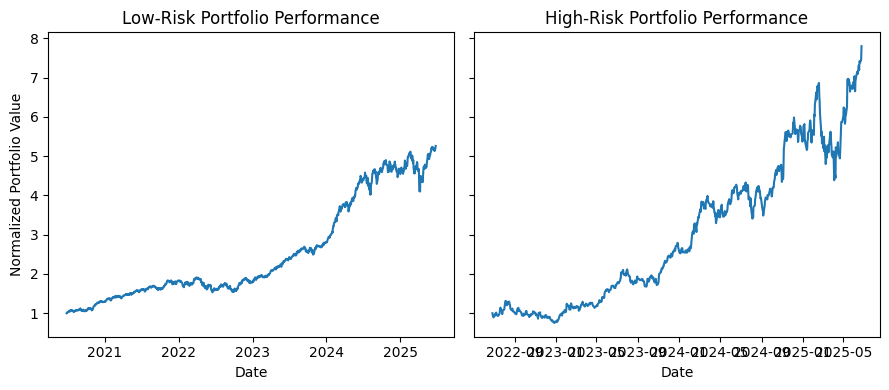

In [44]:
# --- create a 1-row, 2-column figure ---
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharey=True)

# --- left subplot, low risk ---
axs[0].plot(low_portfolio_value)
axs[0].set_title("Low-Risk Portfolio Performance")
axs[0].set_xlabel('Date')
axs[0].set_ylabel("Normalized Portfolio Value")

# --- right subplot, high risk ---
axs[1].plot(high_portfolio_value)
axs[1].set_title("High-Risk Portfolio Performance")
axs[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

In [45]:
header = f"{'Portfolio':<10}{'Returns':>10}{'Volatility':>12}{'Vol/Ret':>10}"
print(header)
print('-' * len(header))

print(f"{'Low risk':<10}{low_returns:>10.3f}{low_volatility:>12.3f}{low_ratio:>10.3f}")
print(f"{'High risk':<10}{high_returns:>10.3f}{high_volatility:>12.3f}{high_ratio:>10.3f}")

Portfolio    Returns  Volatility   Vol/Ret
------------------------------------------
Low risk       0.334       0.195     0.583
High risk      0.690       0.489     0.708


Quantitatively, note that the low risk portfolio has a volitility less than half of what the high risk portfolio has. Moreover, note the low volitility to returns ratio -- meaning, for each unit return, you can expect low volitility from this portfolio. On the other hand, for the high risk portfolio, you see large volatility and large returns.

The investment stratedgy for the low risk portfolio is capital preservation with moderate growth. We want stable and modest expected returns with low volatility. For the high risk portfolio, we are looking for growth and we can tolerate volitility. We are okay with large short term swings as they may lead to large long term profits; this is suited for investors with high risk tolerance.